# Projekt MSP1
Cílem tohoto projektu je se seznámit s programovými nástroji využívaných ve statistice a osvojit si základní procedury. Projekt není primárně zaměřen na efektivitu využívání programového vybavení (i když úplně nevhodné konstrukce mohou mít vliv na hodnocení), ale nejvíce nás zajímají vaše statistické závěry a způsob vyhodnocení. Dbejte také na to, že každý graf musí splňovat nějaké podmínky - přehlednost, čitelnost, popisky.

V projektu budete analyzovat časy běhu šesti různých konfigurací algoritmů. Ke každé konfiguraci vzniklo celkem 200 nezávislých běhů, jejichž logy máte k dispozici v souboru [logfiles.zip](logfiles.zip).

Pokud nemáte rozchozené prostředí pro pro spouštění Jupyter notebooku, můžete využití službu [Google Colab](https://colab.google/). Jakákoliv spolupráce, sdílení řešení a podobně je zakázána!

S případnými dotazy se obracejte na Vojtěcha Mrázka (mrazek@fit.vutbr.cz).

__Odevzdání:__ tento soubor (není potřeba aby obsahoval výstupy skriptů) do neděle 22. 10. 2023 v IS VUT. Kontrola bude probíhat na Pythonu 3.10.12; neočekává se však to, že byste používali nějaké speciality a nekompatibilní knihovny. V případě nesouladu verzí a podobných problémů budete mít možnost reklamace a prokázání správnosti funkce. Bez vyplnění vašich komentářů a závěrů do označených buněk nebude projekt hodnocen!

__Upozornění:__ nepřidávejte do notebooku další buňky, odpovídejte tam, kam se ptáme (textové komentáře do Markdown buněk)

__Tip:__ před odevzdáním resetujte celý notebook a zkuste jej spustit od začátku. Zamezíte tak chybám krokování a editací, kdy výsledek z buňky na konci použijete na začátku.

__OTÁZKA K DOPLNĚNÍ:__

_Jméno a login autora_ 

_Jméno_: __Vojtěch Fiala__ 

_Login_: __xfiala61__

## Načtení potřebných knihoven
Načtěte knihovny, které jsou nutné pro zpracování souborů a práci se statistickými funkcemi. Není dovoleno načítat jiné knihovny.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
from zipfile import ZipFile

## Načtení dat do DataFrame
Ze souboru `logfiles.zip` umístěném ve stejném adresáři načtěte data a vytvořte Pandas DataFrame.

Z logu vás budou nejvíce zajímat řádky
```
Configuration: config6
Run: 191
Time of run: 53.298725254089774
```

Můžete využít následující kostru - je vhodné pracovat přímo se ZIP souborem. Jedinou nevýhodou je to, že vám bude vracet _byte_ objekt, který musíte přes funkci `decode` zpracovat.

In [13]:
def load_logfile(f) -> dict:
    """Load a logfile from a file-like object and return a dict with the data."""
    data = {
        "conf": None,
        "run": None,
        "time": np.nan
    }

    for line in f:
        line = line.decode("utf-8")
        # Urci co je za radek
        if (line[0] == "C"): # Configuration
            config_name = line.split(" ")[1] # Druhe slovo je nazev konfigurace
            if (config_name[-1] == '\n'): # Posledni charakter je newline => odstran ho
                config_name = config_name[:-1]
            data["conf"] = config_name
            
        elif (line[0] == "R"): # Run
            run_number = line.split(" ")[1] # Druhe slovo je cislo behu
            if (run_number[-1] == '\n'): # Posledni charakter je newline => odstran ho
                run_number = run_number[:-1]
            data["run"] = int(run_number) # save it as a number
            
        elif (line[0] == "T"): # Time of run
            time_of_run = line.split(" ")[3] # Ctvrte slovo je doba behu
            if (time_of_run[-1] == '\n'): # Posledni charakter je newline => odstran ho
                time_of_run = time_of_run[:-1]
            data["time"] = np.float64(time_of_run) # Uloz dobu behu jako numpy float
        # Beru v potaz jenom validni radky, ktere ovsem muzou obsahovat neplatne hodnoty
    return data

data = []
with ZipFile("logfiles.zip") as zf:
    for filename in zf.namelist():
        with zf.open(filename, "r") as f:
            data.append(load_logfile(f))
df = pd.DataFrame(data)

## Analýza a čištění dat
Vhodným způsobem pro všechny konfigurace analyzujte časy běhů a pokud tam jsou, identifikujte hodnoty, které jsou chybné. 

In [14]:

# calculate Z-score 
z_score = np.abs(stats.zscore(df["time"]))
threshold = 0.5 # Z_score values seem to be arounnd 0.2 and lower, so 0.5 has been experimentally chosen based on that and seems tto work
outliers = df["time"][z_score > threshold]

# print the outliyng data
print(df.iloc[outliers.index])



         conf  run     time
9     config1    9  3600.00
62    config1   62     0.01
134   config1  134  3600.00
145   config1  145     0.01
148   config1  148  3600.00
184   config1  184     0.01
197   config1  197     0.01
213   config2   13  3600.00
240   config2   40  3600.00
342   config2  142     0.01
441   config3   41     0.01
513   config3  113     0.01
566   config3  166  3600.00
584   config3  184     0.01
587   config3  187     0.01
695   config4   95  3600.00
903   config5  103  3600.00
918   config5  118     0.01
980   config5  180  3600.00
1056  config6   56     0.01
1060  config6   60     0.01
1076  config6   76  3600.00
1110  config6  110  3600.00


__OTÁZKA K DOPLNĚNÍ:__

_Objevily se nějaké chybné hodnoty? Proč tam jsou s ohledem na to, že se jedná o běhy algoritmů?_

Objevily, nachází se při všech config hodnotách a jedná se o hodnoty 3600 a 0.01, což odpovídá v sekundách 1 hodině, respektive 0.01 vteřiny. 
Je možné, že 1 hodina byla zvolena jako "cutoff" hodnota a po uplynutí tohoto času byla činnost algoritmu automaticky ukončena, tzn. algoritmus se např. zasekl v nekonečné smyčce aniž by dosáhl ukončující podmínky.
Nízká hodnota 0.01 pak může být dána např. tím, že data, nad kterými algoritmus prováděl operace, již požadované vlastnosti splňovala a algoritmus tedy jen "zkontroloval", že data splňují co mají a skončil téměř instantně.

Vyčistěte dataframe `df` tak, aby tam tyto hodnoty nebyly a ukažte znovu analýzu toho, že čištění dat bylo úspěšné. Odtud dále pracujte s vyčištěným datasetem.

In [15]:
print(df.shape[0])
df = df.drop(outliers.index)
print(df.shape[0])

1200
1177


## Deskriptivní popis hodnot
Vypište pro jednotlivé konfigurace základní deskriptivní parametry času pro jednotlivé konfigurace.  

__TIP__ pokud výsledky uložíte jako Pandas DataFrame, zobrazí se v tabulce.

In [16]:
# iterate through all unique configs
for config in df["conf"].unique():
    # get descriptive paramters for each config
    print("\nCONFIG: " + str(config))
    print(df.loc[df["conf"] == config]["time"].describe())


CONFIG: config1
count    193.000000
mean      99.590413
std        9.386788
min       73.802549
25%       92.979469
50%       99.865028
75%      104.824724
max      127.201692
Name: time, dtype: float64

CONFIG: config2
count    197.000000
mean     151.732975
std       19.833198
min       85.174653
25%      137.995662
50%      151.516091
75%      163.802880
max      227.054630
Name: time, dtype: float64

CONFIG: config3
count    195.000000
mean     138.616959
std       19.867428
min       90.567110
25%      124.803901
50%      138.678404
75%      151.536291
max      201.577616
Name: time, dtype: float64

CONFIG: config4
count    199.000000
mean     110.317016
std       30.656816
min       29.093401
25%       88.742158
50%      110.782732
75%      130.665606
max      188.971462
Name: time, dtype: float64

CONFIG: config5
count    197.000000
mean     183.659767
std       28.729836
min      107.283620
25%      164.070091
50%      183.843132
75%      201.250693
max      255.807973
Name: t

__OTÁZKA K DOPLNĚNÍ:__

_Okomentujte, co všechno můžeme z parametrů vyčíst._

Z parametrů můžeme pro každou konfiguraci vyčíst průměrnou dobu běhu. medián doby běhu, standardní odchylku, nejnižší a nejvyšší hodnoty a 25% a 75% kvartily.

Podle počtu výsledků spadajících k jednotlivým konfiguracím můžeme zjistit, že nejvíce nevalidních výsledků bylo při nastavení config1, jelikož má méně hodnot než ostatní - nejvíce hodnot bylo smazáno. 

Config1 měl nejnižší průměrný čas běhu (\~99), config5 měl nejvyšší průměrný čas běhu (\~183).

Config5 měl nejvyšší nejkratší dobu běhu - \~107. Config 4 měl ze všech nejrychlejší minimální dobu běhu - \~29, ovšem v průměru je spíše pomalejší (110).

Všechny konfigurace mají po smazaní krajních hodnot velmi podobný průměr i medián.

## Vizualizace
Vizualizujte časy běhů algoritmů v jednom kompaktním grafu tak, aby byl zřejmý i rozptyl hodnot. Zvolte vhodný graf, který pak níže komentujte.

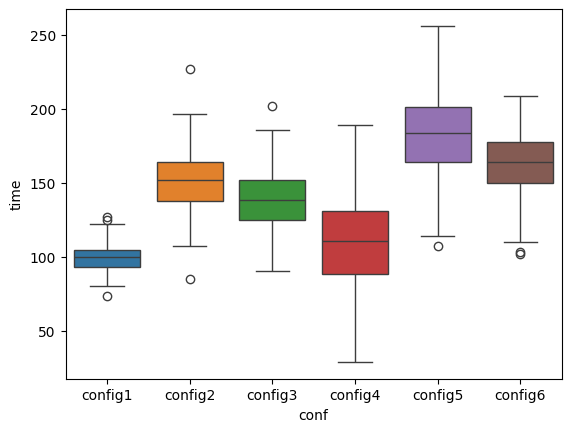

In [17]:
s = sns.boxplot(data=df, x="conf", y="time", hue="conf")

__OTÁZKA K DOPLNĚNÍ:__

_Okomentujte  výsledky z tabulky._

Zvolil jsem krabicový graf, který ukazuje dobu běhu (osa Y) pro jednotlivé konfigurace (osa X).
Z grafu lze vidět, že jak už ukazovali základní deskriptivní parametry, config1 má nejnižší medián běhu a většina jeho běhů je velmi podobná (je velmi malý rozdíl mezi 25. a 75. kvartilem). 

Config1 a config4 se zdají být podobné, kdy config4 dosahuje nižších hodnot, ale v průměru je pomalejší než config1.

Nejvyšší průměrnou dobu běhu a hodnoty mezi 25. a 75. kvartilem má config5, což opět potvrzuje základní parametry.

## Určení efektivity konfigurací algoritmů
Nás ale zajímá, jaká konfigurace je nejrychlejší. Z výše vykresleného grafu můžeme vyloučit některé konfigurace. Existuje tam však minimálně jedna dvojice, u které nedokážeme jednoznačně určit, která je lepší - pokud nebudeme porovnávat pouze extrémní hodnoty, které mohou být dané náhodou, ale celkově. Proto proveďte vhodný test významnosti - v následující části diskutujte zejména rozložení dat (i s odkazem na předchozí buňky, variabilitu vs polohu a podobně). Je nutné každý logický krok a výběry statistických funkcí komentovat. Můžete i přidat další buňky.

Vužijte vhodnou funkci z knihovny `scipy.stats` a funkci poté __implementujte sami__ na základě základních matematických funkcí knihovny `numpy` případně i funkcí pro výpočet studentova rozložení v [scipy.stats](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.t.html). Při vlastní implementaci není nutné se primárně soustředit na efektivitu výpočtu (není potřeba využít všechny funkce numpy, můžete použít normální cykly a podobně - v hodnocení však bude zahrnuta přehlednost a neměly by se objevit jasné chyby, jako je zvýšení třídy složitosti a podobně).

__OTÁZKA K DOPLNĚNÍ:__

_Jaká data budete zkoumat? Jaké mají rozložení a parametry (např. varianci) a jaký test použijete? Jaká je nulová hypotéza? Jak se liší variabilita a poloha vybraných konfigurací?_

In [32]:
# Budu zkoumat casy behu konfiguraci 1 a 4
print("Config1 variance", df.loc[df["conf"] == "config1"]["time"].var())
print("Config4 variance",  df.loc[df["conf"] == "config4"]["time"].var())
# Konfigurace 1 ma median ~99, standardni odchylku ~9 a rozptyl ~88. Konfigurace 4 ma median ~110, standardni odchylku ~30 a rozptyl 939.
# Rozptyl u konfigurace 4 je vyrazne vyssi, stejne jako standardni odchylka, coz potvrzuje i vetsi rozdil mezi hodnotami 25. a 75. kvartilu.

# Pouziju Studentuv T-Test (https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ttest_ind.html), ktery slouzi k porovnani 2 nezavislych vysledku.
# Nulova hypoteza je "config1 a config4 jsou stejne rychle"
# Alternativni hypoteza je "config1 a config4 nejsou stejne rychle"
config1_times = df[df["conf"] == "config1"]["time"] # casy configu 1
config4_times = df[df["conf"] == "config4"]["time"] # casy configu 4

t_statistic, p_value = stats.ttest_ind(config1_times, config4_times, equal_var=False) # equal_var=False, protoze mam rozdilne pocty hodnot -  Welchuv T-Test

# Zkontrolovat, ze toto interpretuju spravne
significance = 1 - 0.99 # 0.01%
if (p_value < significance):
    print("Odmitam nulovou hypotezu, ze jsou obe konfigurace stejne rychle, na hladine vyznamnosti 0.99")
else:
    print("Na hladine vyznamnosti 0.99 nelze nulovou hypotezu odmitnout")


Config1 variance 88.11179094342776
Config4 variance 939.840347192918
Odmitam nulovou hypotezu, ze jsou obe konfigurace stejne rychle, na hladine vyznamnosti 0.99


__OTÁZKA K DOPLNĚNÍ:__

_Jaký je závěr statistického testu?_

Nulová hypotéza, tedy že jsou konfigurace 1 a 4 stejně rychlé, byla odmítnuta na hladině významnosti 0.99. Je tdy pravděpodobné, že nejsou stejně rychlé.

Jejich podobnost je tedy nejspíš čistě náhodná a na základě ostatních parametrů (standardní odchylka, medián, rozdíly mezi kvartily 25. a 75.) se domnívám, že konfigurace 1 je efektivnější než konfigurace 4.

In [ ]:
# TODO vlastni implementace zvoleneho testu